In [1]:
import pandas as pd
import numpy as np
import glob
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# specify parameters that are used
# specifying binning size and last edge
binsize = 4
max_bin_Edge = 25

# number of bins for describing distribution
nbin = 25

In [3]:
outpath_fig = './dataFolders/Output/Figures/Distributions/KLDivergence/'
outpath = './dataFolders/Output/Step8_PDFs and KL Divergence/'
path = './dataFolders/Output/Step6_FloralTypeConsolidatedData_AndFitParameters/'

In [4]:
# read in All Data
shapes = ['c-1', 'c-2', 'c-3', 'c-10']
AllShapes = pd.DataFrame([])

for floralShape in shapes:
    file = glob.glob(path + floralShape + '_Alltrials.csv')[0]
    data = pd.read_csv(file)
    AllShapes = AllShapes.append(data)

In [5]:
# create a subset of the data that contains only the notoutliers

AllShapes_notnull = AllShapes[AllShapes.DiscoveryTime.notnull()].copy()
z = np.abs(stats.zscore(AllShapes_notnull.DiscoveryTime.values))
outlier_ID = z > 5 

AllShapes_notnull.loc[:,'zscore'] = pd.Series(data = z, index = AllShapes_notnull.index)
AllShapes_notnull.loc[:,'outlier_ID'] = pd.Series(data = outlier_ID, index = AllShapes_notnull.index)

notoutliers = AllShapes_notnull.loc[AllShapes_notnull['outlier_ID'] == False].copy()

In [6]:
notoutliers.head()

,Unnamed: 0,MothIn,MothOut,ProboscisDetect,DiscoveryTime,trialNum,name,zscore,outlier_ID
0,0,31485,33858,31825.0,340.0,0,c-1_m10,0.165041,False
1,1,35183,36433,35616.0,433.0,1,c-1_m10,0.012237,False
2,2,37230,37741,37351.0,121.0,2,c-1_m10,0.524871,False
4,4,38344,38965,38438.0,94.0,4,c-1_m10,0.569234,False
5,5,41099,42187,41423.0,324.0,5,c-1_m10,0.191330,False


In [7]:
# Analyze each flowerShape

for flowerShape in shapes:
    flower = notoutliers.loc[notoutliers.name.str.contains(flowerShape), ['DiscoveryTime', 'trialNum', 'name']].copy()

    permuted_df = pd.read_csv(outpath + 'permuted_df_' + flowerShape + '.csv')
    
    # perform analysis on binned Data
    bin_id = np.arange(0,max_bin_Edge, binsize)
    bin_id = np.append(bin_id,max(flower.trialNum)+1)
    
    # build the KL matrix for permutated data
    columns = bin_id[1:]
    index = np.arange(1000)
    KL_matrix = pd.DataFrame(data = None, index=index, columns = columns)
    KL_matrix = KL_matrix.astype(np.float)
    KL_matrix.head()
    
    # now lets do build our KL divergence 95% confidence interval
    
    # reference flower data
    ref_data = flower.loc[flower.trialNum > max_bin_Edge, 'DiscoveryTime' ].values/100 
    Q_dist, bin_hist = np.histogram(ref_data, bins = nbin)
    
    # get the KL divergence for permuted dataset
    for binEdge in columns:
        for permuteNum in range(1000):
                test_data = permuted_df.loc[(permuted_df.permuteNumber == permuteNum) & 
                                            (permuted_df.trialNum < binEdge) & (permuted_df.trialNum >= binEdge - binsize),
                                            'DiscoveryTime'].values/100
                P_dist, _ = np.histogram(test_data, bins = bin_hist)
                epsilon = 1e-30
                P = P_dist + epsilon
                Q = Q_dist + epsilon
                KL = stats.entropy(P, Q)
                KL_matrix.loc[permuteNum,binEdge] = KL
                
    CI = np.percentile(KL_matrix, [5, 95], axis=0, out=None, overwrite_input=False, interpolation='linear', keepdims=True)
    
    KL_matrix.to_csv(outpath + 'permuted_KL_P-dist_binned_' + flowerShape + '.csv')
    
    # get the KL divergence for the real data
    KL_matrix_data = pd.Series(data = None, index = columns, dtype = 'float64')

    for binEdge in columns:
        test_data = flower.loc[(flower.trialNum < binEdge) & 
                               (flower.trialNum >= binEdge - binsize)].DiscoveryTime.values/100
        P_dist, _ = np.histogram(test_data, bins = bin_hist)
        epsilon = 1e-30
        P = P_dist + epsilon
        Q = Q_dist + epsilon
        KL = stats.entropy(P, Q)
        KL_matrix_data.loc[binEdge] = KL
    
    KL_matrix_data.to_csv(outpath + 'KL_forRealData_P-dist_binned_' + flowerShape + '.csv')

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


<Figure size 432x288 with 0 Axes>

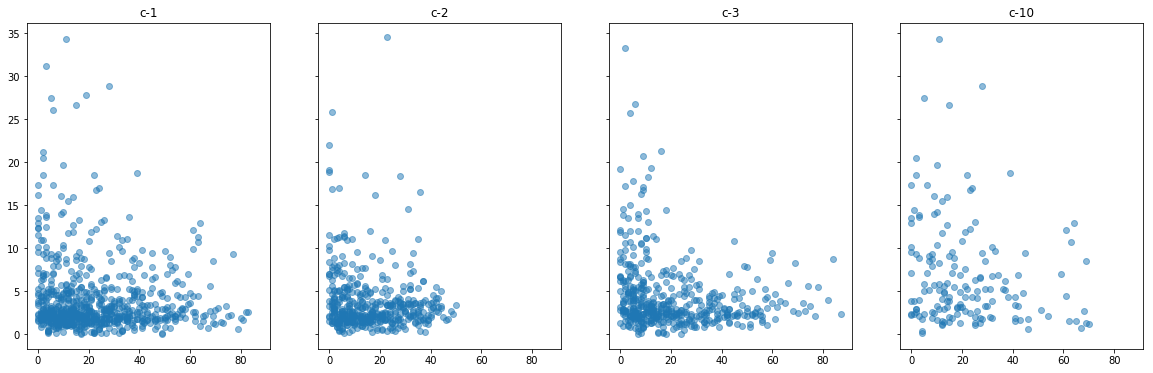

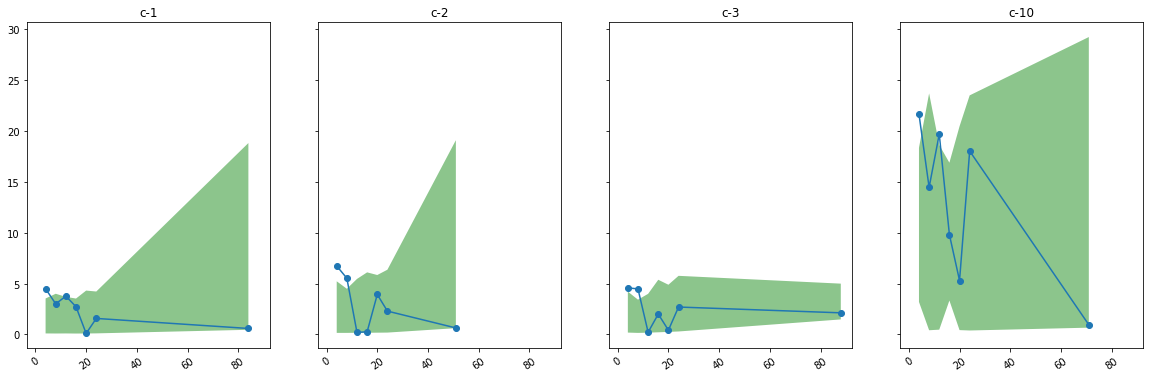

In [9]:
# figure for raw values
plt.figure(1)
fig1, ax1 = plt.subplots(1,4,figsize = (20,6), sharex = True, sharey= True)
ax1=ax1.ravel()

# figure for KL divergence trends
plt.figure(2)
fig2, ax2 = plt.subplots(1,4,figsize = (20,6), sharex = True, sharey= True)
ax2=ax2.ravel()

fig_cc = 0
for flowerShape in shapes:
    flower = notoutliers.loc[notoutliers.name.str.contains(flowerShape), ['DiscoveryTime', 'trialNum', 'name']].copy()

    # just plot the raw data for sanity check
    All = flower.DiscoveryTime.values/100
    ax1[fig_cc].plot(flower.trialNum, All, 'o', alpha = 0.5)
    ax1[fig_cc].set_title(flowerShape)
    
    KL_matrix = pd.read_csv(outpath + 'permuted_KL_P-dist_binned_' + flowerShape + '.csv', index_col=0)
    CI = np.percentile(KL_matrix, [5, 95], axis=0, out=None, overwrite_input=False, interpolation='linear', keepdims=True)
    KL_matrix_data = pd.Series.from_csv(outpath + 'KL_forRealData_P-dist_binned_' + flowerShape + '.csv', index_col=0, header = None)
    
    bin_id = np.arange(0,max_bin_Edge, binsize)
    bin_id = np.append(bin_id,max(flower.trialNum)+1)
    
    columns = bin_id[1:]
    
    ax2[fig_cc].plot(columns, KL_matrix_data, marker = 'o')
    ax2[fig_cc].fill_between(columns, CI[0,:][0], CI[1,:][0], facecolor = 'green', alpha = 0.45)
    plt.figure(2)
    ax2[fig_cc].plot(1,1)
    ax2[fig_cc].set_title(flowerShape)
    plt.sca(ax2[fig_cc])
    plt.xticks(rotation=35)
    
    fig_cc+=1

fig1.savefig(outpath_fig + 'DiscoveryTimeWithVisitNumer_P-dist_binned.png')
fig2.savefig(outpath_fig + 'KLDivergenceWithPermutation_P-dist_binned.png')

# plot the PDFs to confirm by eye what the distributions look like

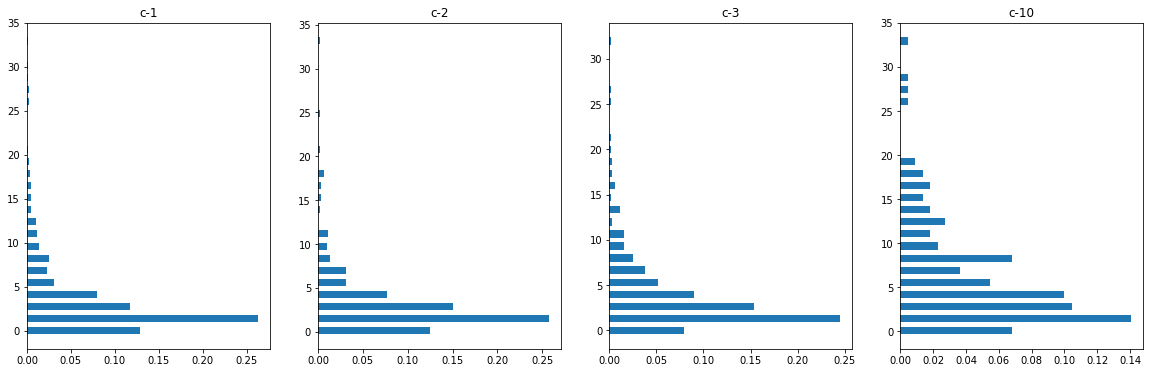

In [232]:
from sklearn.neighbors import KernelDensity

fig, ax = plt.subplots(1,4, figsize = (20,6))
ax = ax.ravel()
i = 0 
for flowerShape in shapes:
    flower = notoutliers.loc[notoutliers.name.str.contains(flowerShape), ['DiscoveryTime', 'trialNum', 'name']].copy()
    ref_data = flower.DiscoveryTime.values/100
    
    Q_dist, bin_hist = np.histogram(ref_data, bins = nbin, density = True)
    ax[i].barh(bin_hist[:-1], Q_dist)
    ax[i].set_title(flowerShape)
    
#     X_plot = np.linspace(bin_hist[0], bin_hist[-1], 1000)
#     kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(Q_dist[:,np.newaxis])
#     log_dens = kde.score_samples(X_plot[:, np.newaxis])
#     ax[i].plot(np.exp(log_dens), X_plot[:,np.newaxis], '-')
    
    i+=1

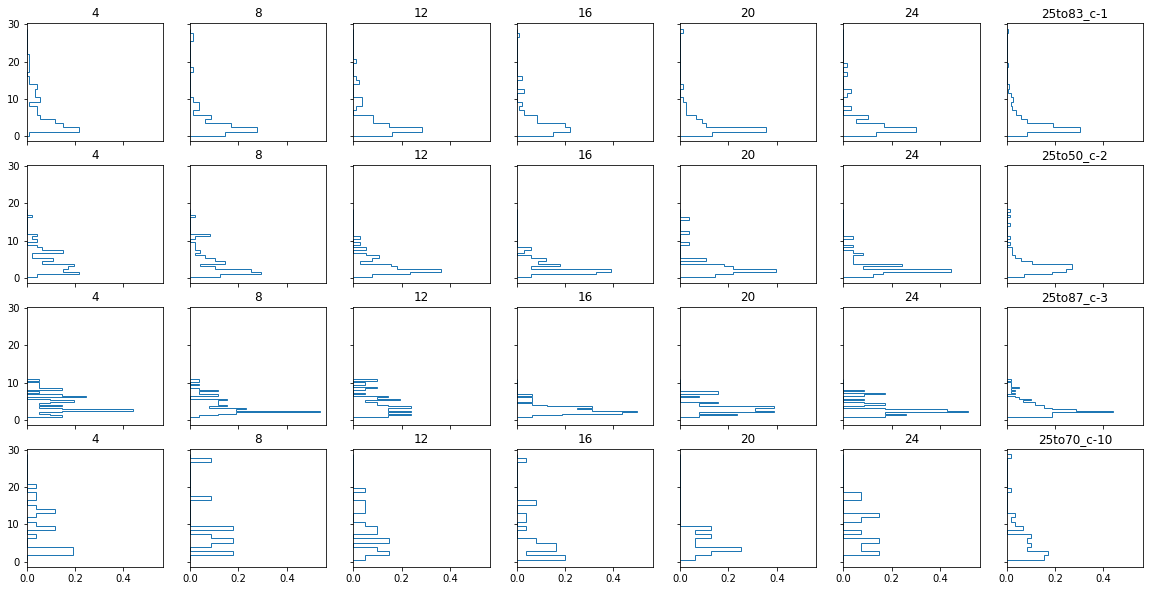

In [17]:
bin_id = np.arange(0,max_bin_Edge, binsize)
# number of subplots
subplot_num = len(bin_id)

fig, ax = plt.subplots(4,subplot_num, figsize = (20,10), sharex = True, sharey = True)
# ax = ax.ravel()

fig_cc = 0
for flowerShape in shapes:
    i = 0
    flower = notoutliers.loc[notoutliers.name.str.contains(flowerShape), ['DiscoveryTime', 'trialNum', 'name']].copy()
    
    ref_data = flower.loc[flower.trialNum > max_bin_Edge, 'DiscoveryTime' ].values/100 
    Q_dist, bin_hist = np.histogram(ref_data, bins = nbin)
    ax[fig_cc, subplot_num-1].hist(ref_data, bin_hist,
              orientation = 'horizontal',
              density = True,
              histtype = 'step')
    ax[fig_cc, subplot_num-1].set_title(str(max_bin_Edge) + 'to' + str(max(flower.trialNum)) + '_' + flowerShape)

    
    bin_id = np.append(bin_id,max(flower.trialNum)+1)
    
    for binEdge in bin_id[1:-1]:
        label = binEdge
        test_data = flower.loc[(flower.trialNum < binEdge) & 
                               (flower.trialNum >= binEdge - binsize)].DiscoveryTime.values/100
        P_dist, P_bin = np.histogram(test_data, bins = nbin, density = True)
        ax[fig_cc, i].hist(test_data, bin_hist,
              orientation = 'horizontal',
              density = True,
              histtype = 'step')
        ax[fig_cc, i].set_title(binEdge)
        i+=1
   
    fig_cc+=1
    bin_id = bin_id[:-1]
fig.savefig(outpath_fig + 'distributions_P-dist_binned_.png')